**Imports**

In [93]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

# Feature Selection
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import LassoLars
from sklearn.neural_network import MLPRegressor

import matplotlib.mlab as mlab

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

**Loading Data**

**Data Fields**

SOC, pH, Ca, P, Sand are the five target variables for predictions. The data have been monotonously transformed from the original measurements and thus include negative values.

- PIDN: unique soil sample identifier

- SOC: Soil organic carbon
- pH: pH values
- Ca: Mehlich-3 extractable Calcium
- P: Mehlich-3 extractable Phosphorus

- Sand: Sand content

- m7497.96 - m599.76: There are 3,578 mid-infrared absorbance measurements. For example, the "m7497.96" column is the absorbance at wavenumber 7497.96 cm-1. We suggest you to remove spectra CO2 bands which are in the region m2379.76 to m2352.76, but you do not have to.

- Depth: Depth of the soil sample (2 categories: "Topsoil", "Subsoil")

Some potential spatial predictors from remote sensing data sources are also included. Short variable descriptions are provided below and additional descriptions can be found at AfSIS data. The data have been mean centered and scaled.

- BSA: average long-term Black Sky Albedo measurements from MODIS satellite images (BSAN = near-infrared, BSAS = shortwave, BSAV = visible)
- CTI: compound topographic index calculated from Shuttle Radar Topography Mission elevation data
- ELEV: Shuttle Radar Topography Mission elevation data
- EVI: average long-term Enhanced Vegetation Index from MODIS satellite images.
- LST: average long-term Land Surface Temperatures from MODIS satellite images (LSTD = day time temperature, LSTN = night time temperature)
- Ref: average long-term Reflectance measurements from MODIS satellite images (Ref1 = blue, Ref2 = red, Ref3 = near-infrared, Ref7 = mid-infrared)
- Reli: topographic Relief calculated from Shuttle Radar Topography mission elevation data
- TMAP & TMFI: average long-term Tropical Rainfall Monitoring Mission data (TMAP = mean annual precipitation, TMFI = modified Fournier index)

In [94]:
# Load training data
X = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive

n = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  max_rows = 1,
                  names = True,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive
feature_names = np.asarray(n.dtype.names)

Depth = np.genfromtxt('training.csv',
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=3594) # Load Depth values

PIDN = np.genfromtxt('training.csv',
                    delimiter=',',
                    dtype=None,
                    skip_header = 1,
                    usecols=0) # Load the PIDN for reference

Ca = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3595) # Load Mehlich-3 extractable Calcium data

P = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3596) # Load Mehlich-3 extractable Phosphorus data

pH = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3597) # Load pH data

SOC = np.genfromtxt('training.csv', 
                    delimiter=',', 
                    dtype=None,
                    skip_header = 1,
                    usecols=3598) # Load Soil Organic Carbon data

Sand = np.genfromtxt('training.csv', 
                     delimiter=',', 
                     dtype=None,
                     skip_header = 1,
                     usecols=3599) # Load Sand Content data

# Shuffle the input: create a random permutation of the integers between 0 and the number of data 
# points and apply this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Depth, PIDN, Ca, P, pH, SOC, Sand = X[shuffle], Depth[shuffle], PIDN[shuffle], Ca[shuffle], \
    P[shuffle], pH[shuffle], SOC[shuffle], Sand[shuffle] 

# Outcome (response) variable list
outcome_vars = ['Ca', 'P', 'pH', 'Soc', 'Sand']

# Color map for outcome variables
colors = ['orange', 'yellowgreen', 'powderblue', 'sienna', 'tan']


In [95]:
# Load test data
test_x = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=range(1, 3594)) # Load columns 0 to 3594 inclusive

test_depth = np.genfromtxt('sorted_test.csv',
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=3594) # Load Depth values

test_ids = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=0) # Load the ID column

In [96]:
# Inspect the data shapes

print '\n-------------------------------------------'
print "Training data shape: ", X.shape
print "Feature name shape: ", feature_names.shape
print "PIDN data shape: ", PIDN.shape
print "Depth data shape: ", Depth.shape
print "Ca data shape: ", Ca.shape
print "P data shape: ", P.shape
print "pH data shape: ", pH.shape
print "SOC data shape: ", SOC.shape
print "Sand data shape: ", Sand.shape
print "Test data shape: ", test_x.shape
print "Test_depth data shape: ", test_depth.shape
print "Test_ids data shape: ", test_ids.shape


-------------------------------------------
Training data shape:  (1157, 3593)
Feature name shape:  (3593,)
PIDN data shape:  (1157,)
Depth data shape:  (1157,)
Ca data shape:  (1157,)
P data shape:  (1157,)
pH data shape:  (1157,)
SOC data shape:  (1157,)
Sand data shape:  (1157,)
Test data shape:  (727, 3593)
Test_depth data shape:  (727,)
Test_ids data shape:  (727,)


Ca: total = 1157, max = 9.65, mean = 0.01, min = -0.54
P: total = 1157, max = 13.27, mean = -0.01, min = -0.42
pH: total = 1157, max = 3.42, mean = -0.03, min = -1.89
SOC: total = 1157, max = 7.62, mean = 0.08, min = -0.86
Sand: total = 1157, max = 2.25, mean = -0.01, min = -1.49


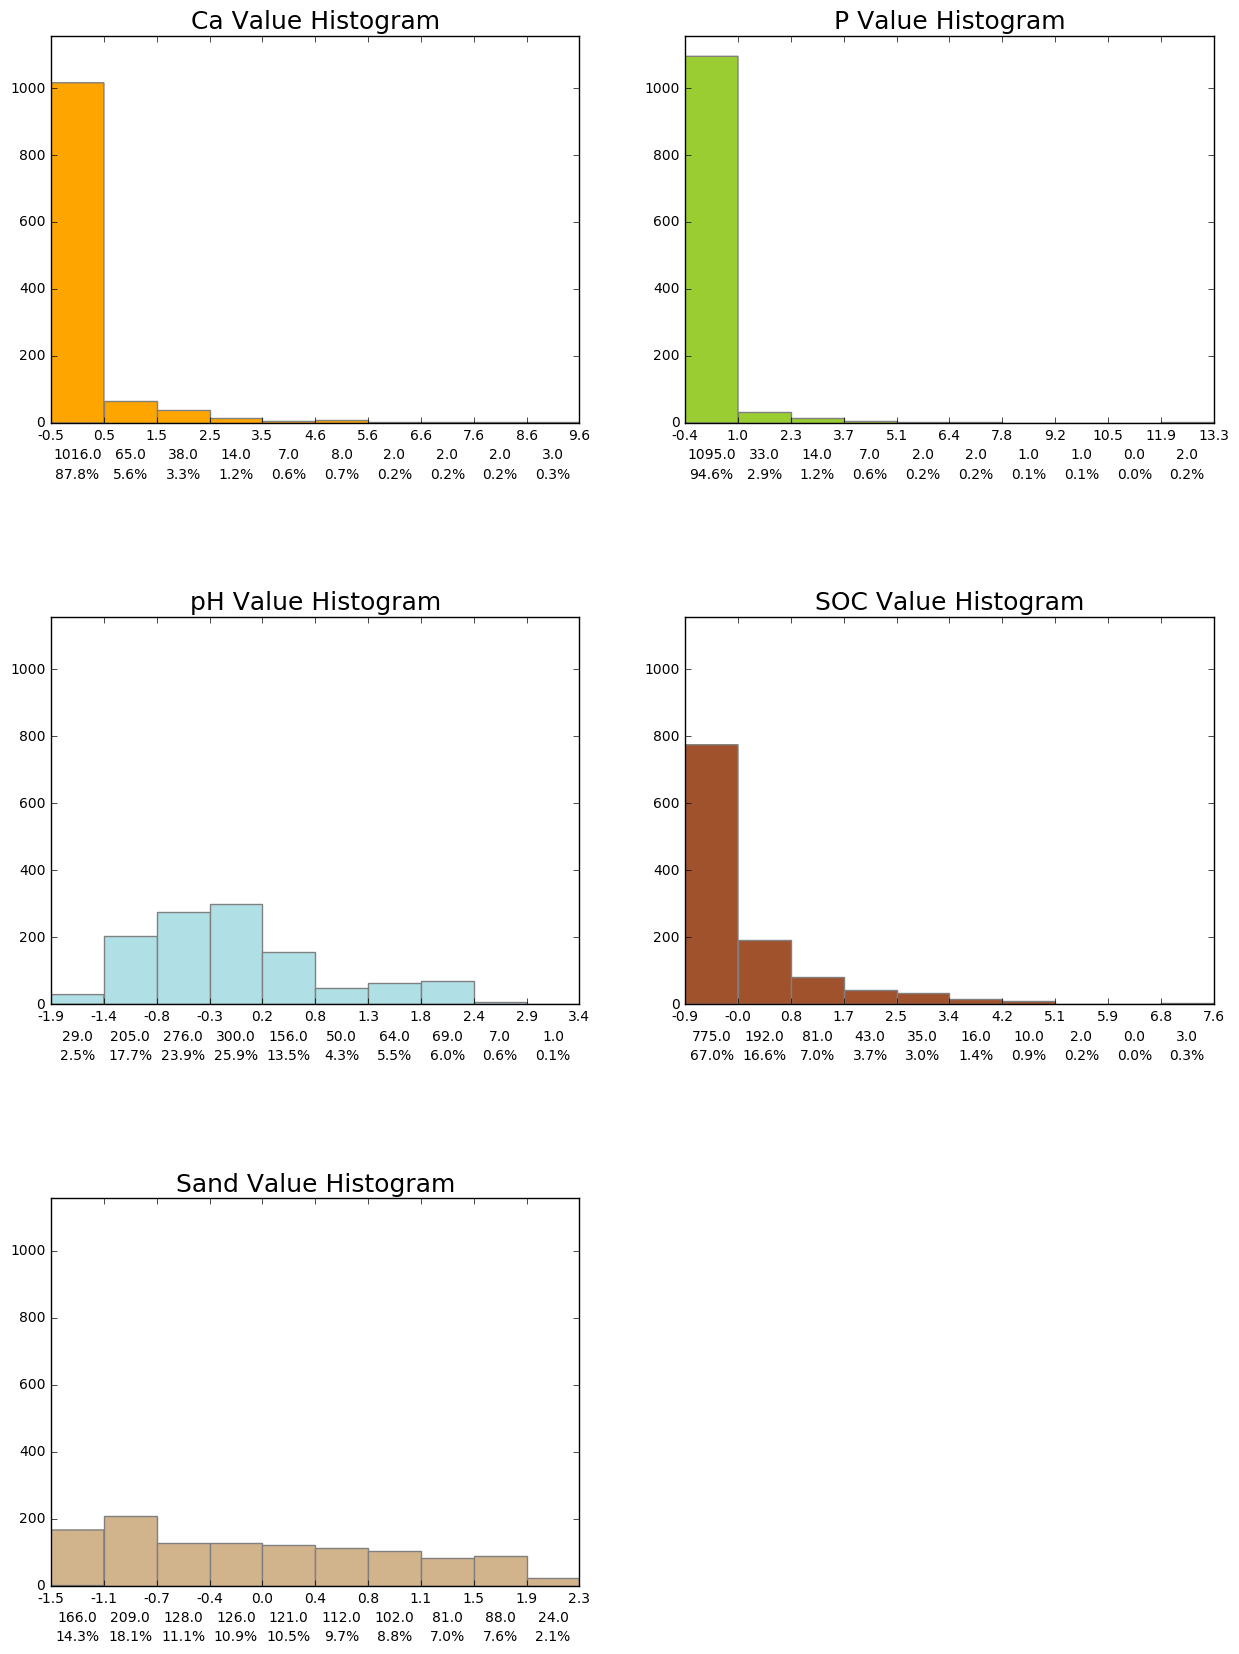

In [98]:
# Inspect the data in the five response variables

print "Ca: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Ca.shape[0], np.max(Ca), np.mean(Ca), np.min(Ca))
print "P: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (P.shape[0], np.max(P), np.mean(P), np.min(P))
print "pH: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (pH.shape[0], np.max(pH), np.mean(pH), np.min(pH))
print "SOC: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (SOC.shape[0], np.max(SOC), np.mean(SOC), np.min(SOC))
print "Sand: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Sand.shape[0], np.max(Sand), 
                                                                  np.mean(Sand), np.min(Sand))

def plot_hist(ind, data, max_y, title, color):

    counts, bins, patches = ax[ind].hist(data, facecolor=color, edgecolor='gray')
    # set the ticks to be at the edges of the bins.
    ax[ind].set_xticks(bins)
    # set the limits for x and y
    ax[ind].set_xlim([np.min(data),np.max(data)])
    ax[ind].set_ylim([0,max_y])
    # set the xaxis's tick labels to be formatted with 1 decimal place
    ax[ind].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax[ind].set_title(title, fontsize=18)
  
    # Label the raw counts and the percentages below the x-axis
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax[ind].annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.1f%%' % (100 * float(count) / counts.sum())
        ax[ind].annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


fig, ax = plt.subplots(3, 2, figsize=(15, 20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# Ca
plot_hist(0, Ca, Ca.shape[0], 'Ca Value Histogram', colors[0])
# P
plot_hist(1, P, P.shape[0], 'P Value Histogram', colors[1])
#pH
plot_hist(2, pH, pH.shape[0], 'pH Value Histogram', colors[2])
#SOC
plot_hist(3, SOC, SOC.shape[0], 'SOC Value Histogram', colors[3])
#Sand
plot_hist(4, Sand, Sand.shape[0], 'Sand Value Histogram', colors[4])
# delete the last subplot
fig.delaxes(ax[5])

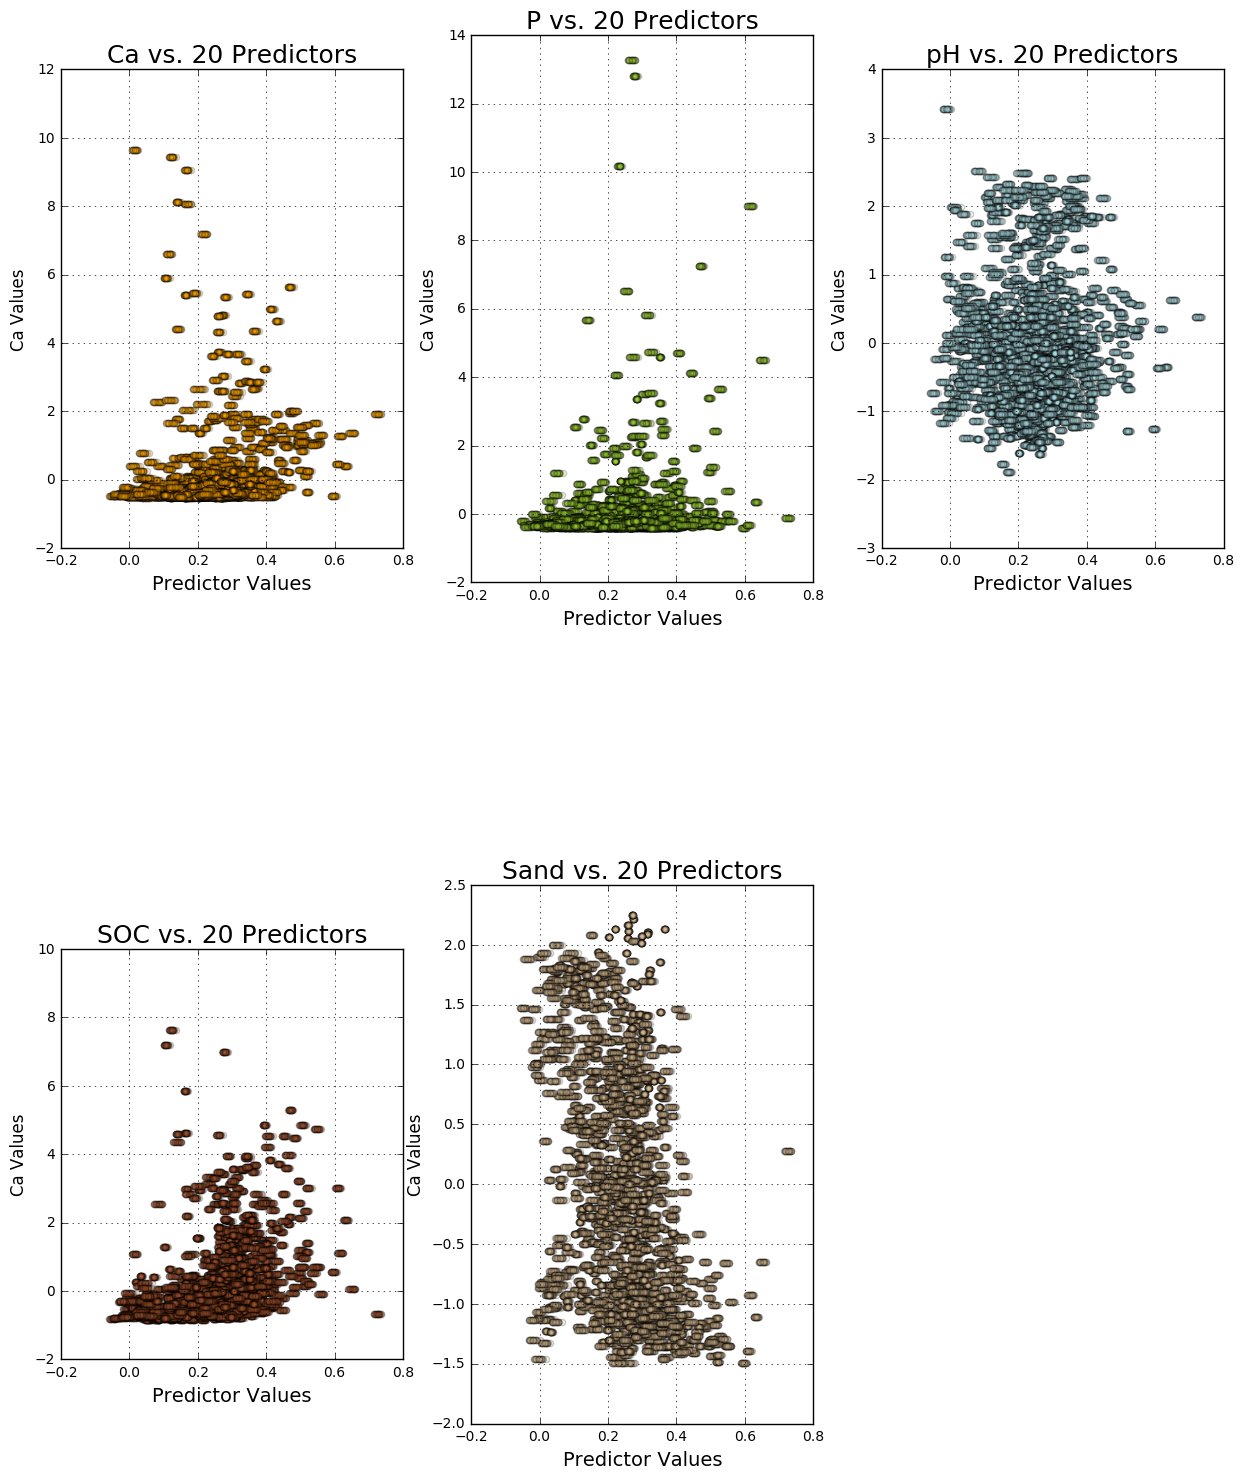

In [99]:
# Inspect the data in the predictor variables

def plot_data(ind, data_x, data_y, aspect, title, color):
    
    ax[ind].set_title(title, fontsize=18)
    ax[ind].set_xlabel('Predictor Values', fontsize=14)
    ax[ind].set_ylabel('Ca Values', fontsize=12)
    ax[ind].set_aspect(aspect = aspect, adjustable='box')
    ax[ind].grid(True)
    ax[ind].scatter(data_x, data_y, color = color, alpha = 0.2, marker = 'o', edgecolors = 'black')

# set up the grid plot
fig, ax = plt.subplots(2, 3, figsize=(15, 20))
#fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# select the predictor range (note this is influenced by the PCA below)
my_col = 20

X_sub = np.ravel(X[:,:my_col].reshape(-1,1))

# Ca 
plot_data(0, X_sub, np.repeat(Ca, my_col), 0.1, 'Ca vs. %d Predictors' % my_col, colors[0])
# P 
plot_data(1, X_sub, np.repeat(P, my_col), 0.1, 'P vs. %d Predictors' % my_col, colors[1])
#pH 
plot_data(2, X_sub, np.repeat(pH, my_col), 0.2, 'pH vs. %d Predictors' % my_col, colors[2])
#SOC 
plot_data(3, X_sub, np.repeat(SOC, my_col), 0.1, 'SOC vs. %d Predictors' % my_col, colors[3])
#Sand 
plot_data(4, X_sub, np.repeat(Sand, my_col), 0.35, 'Sand vs. %d Predictors' % my_col, colors[4])
# delete the last subplot
fig.delaxes(ax[5])


**Which features have more impact?**

There are over three thousand features in this data, with few rows. Thus, we have a large k but small n data set to work with. Perhaps there is a subset of features to focus on.

Below, we investigate two variations of PCA to explain variances over the features. We observe that the first 20 components explain increasing portions of the variance, however after 20 components, the subsequent ones don't really help. The first 70-80 features will explain ~100% of the variance.


-------------------------------------------
Fraction of the total variance in the training explained by first k components: 

1 	 70.54% 	 66.91% 	 m749796
2 	 79.38% 	 75.72% 	 m749604
3 	 85.54% 	 82.10% 	 m749411
4 	 89.31% 	 85.88% 	 m749218
5 	 91.69% 	 88.83% 	 m749025
6 	 93.63% 	 90.85% 	 m748832
7 	 95.14% 	 92.57% 	 m748639
8 	 96.16% 	 94.10% 	 m748446
9 	 96.75% 	 95.11% 	 m748254
10 	 97.27% 	 95.74% 	 m748061
11 	 97.74% 	 96.29% 	 m747868
12 	 98.10% 	 96.76% 	 m747675
13 	 98.42% 	 97.14% 	 m747482
14 	 98.69% 	 97.49% 	 m747289
15 	 98.90% 	 97.77% 	 m747097
16 	 99.06% 	 98.00% 	 m746904
17 	 99.20% 	 98.21% 	 m746711
18 	 99.34% 	 98.40% 	 m746518
19 	 99.44% 	 98.55% 	 m746325
20 	 99.50% 	 98.69% 	 m746132
21 	 99.56% 	 98.80% 	 m745939
22 	 99.62% 	 98.90% 	 m745747
23 	 99.67% 	 98.99% 	 m745554
24 	 99.72% 	 99.07% 	 m745361
25 	 99.75% 	 99.14% 	 m745168
26 	 99.78% 	 99.20% 	 m744975
27 	 99.81% 	 99.26% 	 m744782
28 	 99.83% 	 99.31% 	 m744589
29 	 99.85% 	 

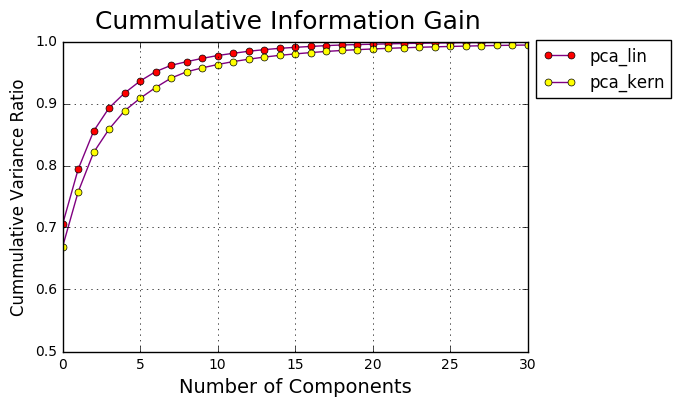

In [100]:
# Linear PCA using all of the features
n_comp = feature_names.shape[0]
pca_lin = PCA(n_components = n_comp)
pca_lin.fit(X)
pca_lin_cumsum = np.cumsum(pca_lin.explained_variance_ratio_)

# Non-linear kernel RBF PCA using all of the features 
pca_kern = KernelPCA(n_components = n_comp, kernel = 'rbf')
pca_kern.fit(X)

# build the explained variance ratio list for pca_kern
explained_var_ratio_kern = []
for i in range(0, pca_kern.lambdas_.shape[0]):
    explained_var_ratio_kern.append(pca_kern.lambdas_[i]/sum(pca_kern.lambdas_))
pca_kern_cumsum = np.cumsum(np.asarray(explained_var_ratio_kern))

# Plot the Information Gain graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_lin_cumsum, color = 'purple', marker = 'o', ms = 5, mfc = 'red', label = 'pca_lin')
ax.plot(pca_kern_cumsum, color = 'purple', marker = 'o', ms = 5, mfc = 'yellow', label = 'pca_kern')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.91), shadow=False, scatterpoints=1)
fig.suptitle('Cummulative Information Gain', fontsize=18)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cummulative Variance Ratio', fontsize=12)
plt.grid(True)
ax.set_xlim([0,30])
ax.set_ylim([0.5,1.0])

# Output variance fractions
print '\n-------------------------------------------'
print 'Fraction of the total variance in the training explained by first k components: \n'
for k in range(1,76): 
    print("%d \t %s \t %s \t %s" % (k, '{0:.2f}%'.format(pca_lin_cumsum[k-1] * 100), 
                                    '{0:.2f}%'.format(pca_kern_cumsum[k-1] * 100), feature_names[k-1]))
    

**Feature selectors**

In [101]:
# Set up the feature selectors to trial

def getFeatureSelectors():
    return [
        #['lasso', SelectFromModel(LassoCV()) ], # Doesn't work
        #['linearc0.01', SelectFromModel(LinearSVC(C=0.01, penalty="l1")) ],
        #['linearc0.1', SelectFromModel(LinearSVC(C=0.1, penalty="l1")) ],
        #['linearc11', SelectFromModel(LinearSVC(C=1, penalty="l1")) ],
        #['kbest100', SelectKBest(k=100)],
        #['kbest250', SelectKBest(k=250)],
        #['pca5', PCA(n_components=5)],
        #['pca10', PCA(n_components=10)],
        ['pca20', PCA(n_components=20)],
        ['pca30', PCA(n_components=30)],
        ['pca30rbf', KernelPCA(n_components=30,kernel='rbf')],
        ['pca20kbest5', FeatureUnion([("pca5", PCA(n_components=20)), ("kbest5", SelectKBest(k=5))])],
        ['pca20kbest50', FeatureUnion([("pca5", PCA(n_components=20)), ("kbest50", SelectKBest(k=50))])],
        ['pca20kbest250', FeatureUnion([("pca5", PCA(n_components=20)), ("kbest250", SelectKBest(k=250))])],
     ]

**Classifiers**

In [103]:
# Prep data for modeling

train_data, dev_data, Depth_train, Depth_dev, Ca_train, Ca_dev, P_train, P_dev, pH_train, pH_dev, \
    SOC_train, SOC_dev, Sand_train, Sand_dev = train_test_split(X, Depth, Ca, P, pH, SOC, Sand)

train_labels = [Ca_train, P_train, pH_train, SOC_train, Sand_train]
dev_labels = [Ca_dev, P_dev, pH_dev, SOC_dev, Sand_dev]

# Inspect the data shapes

print '\n-------------------------------------------'
print "train data shape: ", train_data.shape
print "dev data shape: ", dev_data.shape
print "Depth_train data shape: ", Depth_train.shape
print "Depth_dev data shape: ", Depth_dev.shape
print "Ca_train data shape: ", Ca_train.shape
print "Ca_dev data shape: ", Ca_dev.shape
print "P_train data shape: ", P_train.shape
print "P_dev data shape: ", P_dev.shape
print "pH_train data shape: ", pH_train.shape
print "pH_dev data shape: ", pH_dev.shape
print "SOC_train data shape: ", SOC_train.shape
print "SOC_dev data shape: ", SOC_dev.shape
print "Sand_train data shape: ", Sand_train.shape
print "Sand_dev data shape: ", Sand_dev.shape


-------------------------------------------
train data shape:  (867, 3593)
dev data shape:  (290, 3593)
Depth_train data shape:  (867,)
Depth_dev data shape:  (290,)
Ca_train data shape:  (867,)
Ca_dev data shape:  (290,)
P_train data shape:  (867,)
P_dev data shape:  (290,)
pH_train data shape:  (867,)
pH_dev data shape:  (290,)
SOC_train data shape:  (867,)
SOC_dev data shape:  (290,)
Sand_train data shape:  (867,)
Sand_dev data shape:  (290,)


In [104]:
# Predict the mean value of an array
def PredictMean(labels):
    mean = np.mean(labels)
    mean_array = mean*np.ones(labels.shape)
    return mean_array

# Get the means of the dev data for our reference

print '\n-------------------------------------------'
Ca_mean = PredictMean(Ca_dev)
print 'Calcium Mean: ', Ca_mean[0] 

P_mean = PredictMean(P_dev)
print 'Phosphorus Mean: ', P_mean[0]

pH_mean = PredictMean(pH_dev)
print 'pH Mean: ', pH_mean[0]

SOC_mean = PredictMean(SOC_dev)
print 'SOC Mean: ', SOC_mean[0]

Sand_mean = PredictMean(Sand_dev)
print 'Sand Mean: ', Sand_mean[0]


-------------------------------------------
Calcium Mean:  0.0438257090646
Phosphorus Mean:  0.00645008076791
pH Mean:  0.025710394719
SOC Mean:  0.0286130670532
Sand Mean:  0.0256980369452


In [105]:
# Set up the classifiers to trial

def getClassifiers():
     return [
        ['KNN', KNeighborsRegressor(), {'n_neighbors':[1, 2, 3, 5, 8]}],
        ['SVRdict', SVR(cache_size=200), {'C':[0.1,1.0,100.0,1000.0],'kernel':['linear','rbf']}],
        #['SVR', SVR(cache_size=200, kernel='linear', C=1.0, epsilon=0.05, shrinking=False),{}]
        ['Lasso', Lasso(), {'alpha':[0.01, 0.05, 0.25, 0.9]}],
        #['LassoLars', LassoLars(), {'alpha':[0.01, 0.1, 0.5, 1.0]}],            
        ['RandomForest', RandomForestRegressor(), {'n_estimators':[1, 2, 3, 5, 8]}],
        ['nn', MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(2, 2)), {}]
        #['RandomForest', RandomForestRegressor(), {'n_estimators':[1, 2, 3, 5, 8]}]
    ]

**Test combinations of selectors and classifiers**

In [82]:
# For each outcome variable, for each classifier and for each selector, it will obtain and print 
# the best hyperparameters and inmediately print the mean squared error.
#
# Finally, after finishing the calculations, it will print the methods and score ordered by score (MSE)
# To see what would be the final score we'd get, you can get the best MSE score for each outcome variable,
# and calculate the average of them.

def run():
    
    allResults = []
    
    scaler = Normalizer().fit(train_data)
    
    transformedTrainData = scaler.transform(train_data)
    transformedDevData = scaler.transform(dev_data)

    for outcomeVarIndex in range(0, 5):
        print('*************************************************************')
        print('Outcome Variable:', outcome_vars[outcomeVarIndex])
        print('*************************************************************')

        results = []
            
        scaler = Normalizer().fit(train_data)
        
        # Get the mean value of the outcome variable
        DevMean = PredictMean(dev_labels[outcomeVarIndex])[0]

        for selector in getFeatureSelectors():
            
            selectedTrainData = selector[1].fit(transformedTrainData, 
                                                train_labels[outcomeVarIndex]).transform(transformedTrainData)
            selectedDevData = selector[1].transform(transformedDevData)
                
            for classifier in getClassifiers():

                print('-------------------------------------------------------')
                print(selector[0] + ' ' + classifier[0])

                grid_search = GridSearchCV(classifier[1], param_grid=classifier[2],cv=5)

                grid_search.fit(selectedTrainData, train_labels[outcomeVarIndex])
                print(grid_search.best_estimator_)

                # Mean Squared Error:  (y_true - y_pred)**2.sum()
                meanSquaredError = 0.0
                for i in range(len(selectedDevData)):
                    diff = grid_search.predict(selectedDevData[i].reshape(1, -1)) - dev_labels[outcomeVarIndex][i]
                    squaredDiff = diff ** 2
                    meanSquaredError = meanSquaredError + squaredDiff
                    
                #meanSquaredError = meanSquaredError / float(len(selectedDevData))
                
                # Residual Sum of squares:  (y_true - y_mean)**2.sum()
                residualSquaredError = 0.0
                for i in range(len(selectedDevData)):
                    diff = dev_labels[outcomeVarIndex][i] - DevMean
                    squaredDiff = diff ** 2
                    residualSquaredError = residualSquaredError + squaredDiff     
                    
                myScore = 1 - meanSquaredError/residualSquaredError
                
                print('Mean Squared Error: ', str(meanSquaredError / float(len(selectedDevData))))
                print('Residual Squared Error: ', str(residualSquaredError))
                print('Calculated Score: ', str(1 - meanSquaredError/residualSquaredError))
                print('Score: ' + str(grid_search.score(selectedDevData, dev_labels[outcomeVarIndex])))
                
                # Store in an array, for each combination, the following:
                # [selector name, classifier name, mean squared error, selector instance, classifier instance]
                results.append([selector[0], classifier[0], myScore, selector[1], grid_search])

                                                            
        sortedResults = sorted(results, key=lambda result: result[2], reverse=True)
        for result in sortedResults:
            print('Selector: ' + str(result[0]) + ', Classifier: ' + str(result[1])  + ', Score: ' + str(result[2]))
        
        copyResults = sortedResults[:]
        allResults.append(copyResults)
        
    #TODO Calculate columnwise mean of the mean squared error
    #Each item has the best result on item 0
    squaredErrorSum = 0.0
    
    bestModels = []
    print('-------------------------------------------------------')
    print('Best Results')
    print('-------------------------------------------------------')
    for i in range(len(allResults)):

        columnResults = allResults[i]
        bestColumnResult = columnResults[0]
        squaredError = bestColumnResult[2]
        print('Outcome Variable: ' + outcome_vars[i] + ', Selector: ' + str(bestColumnResult[0]) + 
              ', Classifier: ' + str(bestColumnResult[1])  + ', Score: ' + str(bestColumnResult[2]))
        squaredErrorSum = squaredErrorSum + squaredError
        bestModels.append(bestColumnResult)
        
        
    print('Best result obtained: ' + str(squaredErrorSum / 5.0))
    
    return bestModels

models = run()

*************************************************************
('Outcome Variable:', 'Ca')
*************************************************************
-------------------------------------------------------
pca70 KNN
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
('Mean Squared Error: ', '[ 0.07981822]')
('Residual Squared Error: ', '254.969407087')
('Calculated Score: ', '[ 0.90921544]')
Score: 0.909215443939
-------------------------------------------------------
pca70 SVRdict
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
('Mean Squared Error: ', '[ 0.07003102]')
('Residual Squared Error: ', '254.969407087')
('Calculated Score: ', '[ 0.92034732]')
Score: 0.920347321917
-------------------------------------------------------
pca70 Lasso
Lasso(alpha=0.01, copy_X=True, 

**Predictions based on our dev data**


Test on the evaluation data

In [90]:
myScore = []

scaler = Normalizer().fit(train_data)
transformedDevData = scaler.transform(dev_data)
#transformedEvalData = eval_data

# Use the appropriate model to estimate the 5 outcome variables
for outcomeVarIndex in range(0, 5):
        
    # Grab selector and classifier
    selector = models[outcomeVarIndex][3]
    classifier = models[outcomeVarIndex][4]
        
    # Transform the input variables
    selectedSample = selector.transform(transformedDevData)
        
    # Predict
    myScore.append(classifier.score(selectedSample,dev_labels[outcomeVarIndex]))
        
print(myScore)    

[0.92107640674007973, 0.080586651878408744, 0.80466333457428796, 0.88932328415726192, 0.85058542387502534]


In [91]:
scaler = Normalizer().fit(X)
normalizedTestData = scaler.transform(test_x)
#normalizedTestData = test_x

allPredictions = []

# Iterate through test samples
for sampleIndex in range(len(test_x)):
    
    sampleId = test_ids[sampleIndex]
    sample = normalizedTestData[sampleIndex]
    
    currentSamplePredictions = []
    
    # Use the appropriate model to estimate the 5 outcome variables
    for outcomeVarIndex in range(0, 5):
        
        # Grab selector and classifier
        selector = models[outcomeVarIndex][3]
        classifier = models[outcomeVarIndex][4]
        
        # Transform the input variables
        selectedSample = selector.transform(sample.reshape(1, -1))
        
        # Predict
        predicted = classifier.predict(selectedSample.reshape(1, -1))
        
        # Store
        currentSamplePredictions.append(predicted[0])
    
    allPredictions.append(currentSamplePredictions)
    

print(allPredictions)
       

[[-0.58403570657743575, -0.1909150301909433, -0.84903611740725582, -0.52404121657626757, 1.1336125196767906], [0.60115692775251528, 0.88639711207728689, 1.1974971266651582, -0.41766977548718165, -1.0506234617267143], [-0.10812788364172565, 0.29759328472201824, 0.084227254535089724, -0.1342391951169723, -0.76410674151392977], [-0.24469367868571812, -0.32017519493339963, -0.45537876771951558, 0.74085814844123332, -1.0506234617267143], [-0.46212871466516692, 0.16876542822284751, -1.5630781863725045, 0.45687142669637149, -0.10523414800724362], [-0.6678993524817658, 0.20335008768571255, -0.71116998676150134, -0.52404121657626757, 0.3045401644374004], [-0.41955312479470042, 0.62095985069980175, -1.0618555326368955, 0.72758163678055077, -1.0506234617267143], [-0.23386406434384543, 2.1837541501779909, 0.76600373942487066, -0.52404121657626757, 0.45645706431931066], [0.066794468988365274, -0.14465804815936212, 0.60401912181696593, -0.13553783518817625, -1.0506234617267143], [-0.7088997897589282

**Generate CSV file for kaggle submission**

In [92]:
# Print header
header = 'PIDN,Ca,P,pH,SOC,Sand'
#np.savetxt('test.out', header, delimiter=',')  

filename = 'test7v2.csv'
# Clean file
open(filename, 'w').close()
with open(filename, 'w') as f:
    f.write('PIDN,Ca,P,pH,SOC,Sand\n')  # python will convert \n to os.linesep

    # Iterate through test samples
    for i in range(len(allPredictions)):

        pred = allPredictions[i]
        testId = test_ids[i]
        text = testId + ',' + str(pred[0]) + ',' + str(pred[1]) + ',' + str(pred[2]) + ',' + str(pred[3]) + ',' + str(pred[4]) + '\n'
        f.write(text) 
    
f.close()

Investigation: Sand variable

In [ ]:


#!/usr/bin/env python



# the histogram of the data
n, bins, patches = plt.hist(train_Sand_labels, 50, normed=1, facecolor='green', alpha=0.75)

plt.title(r'$\mathrm{Sand:}$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

scaler = Normalizer().fit(train_data)

transformedTrainData = scaler.transform(train_data)
transformedDevData = scaler.transform(dev_data)

selector = FeatureUnion([("pca5", PCA(n_components=20)), ("kbest5", SelectKBest(k=250))]).fit(transformedTrainData, train_Sand_labels)
#selector = SelectFromModel(LassoCV(), threshold=0.25).fit(transformedTrainData, train_Sand_labels)
selectedTrainData = selector.transform(transformedTrainData)
selectedDevData = selector.transform(transformedDevData)


classifier =  LassoLars(alpha=0.01)#LassoLars is doing very well on dev set, but horribly wrong in test set. bug or really overfitted?
classifier.fit(transformedTrainData, train_Sand_labels)

print classifier.score(transformedDevData, dev_Sand_labels)

meanSquaredError = 0.0
for i in range(len(transformedDevData)):
    diff = classifier.predict(transformedDevData[i].reshape(1, -1)) - dev_Sand_labels[i]
    #print str(classifier.predict(transformedDevData[i].reshape(1, -1))) + ', ' + str(dev_Sand_labels[i])
    squaredDiff = diff ** 2
    meanSquaredError = meanSquaredError + squaredDiff
    

    
print meanSquaredError / float(len(transformedDevData))